In [1]:
import pathlib
import numpy as np
!pip install scikit-plot
import seaborn as sns
from matplotlib import pyplot
import scikitplot
from sklearn.metrics import classification_report
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import os
import time
import tensorflow_hub as hub
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
img_arr = np.load('/content/drive/MyDrive/img_arr.npy')
img_label = np.load('/content/drive/MyDrive/img_label.npy')

In [3]:
label_to_text = {0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'fear'}

In [4]:
print(img_arr.shape, img_label.shape)

(16496, 100, 100, 3) (16496,)


In [5]:
img_arr = img_arr/255

In [6]:
unique_elements, counts_elements = np.unique(img_label, return_counts=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14846, 100, 100, 3), (1650, 100, 100, 3), (14846,), (1650,))

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    shuffle=True, stratify=y_train,
                                                    train_size=0.85, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((12619, 100, 100, 3), (2227, 100, 100, 3), (12619,), (2227,))

In [9]:
del img_arr
del img_label

In [10]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

In [11]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [12]:
num_classes

4

In [13]:
xception = keras.applications.Xception(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

83697664/83683744 [==============================] - 2s 0us/step


In [14]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [15]:
x = xception.output
global_pool = keras.layers.GlobalMaxPool2D(name="global_pool")(x)
out = keras.layers.Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = keras.models.Model(inputs=xception.input, outputs=out)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 49, 49, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 49, 49, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [17]:
filepath="/content/xception-{epoch:02d}-{val_accuracy:.2f}.hdf5"

In [18]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
batch_size = 16
epochs = 50
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    use_multiprocessing=True,
    callbacks = [model_checkpoint_callback]
)

Epoch 1/50
788/788 [==============================] - 82s 80ms/step - loss: 1.1019 - accuracy: 0.5313 - val_loss: 0.9508 - val_accuracy: 0.6246
Epoch 2/50
788/788 [==============================] - 61s 77ms/step - loss: 0.8936 - accuracy: 0.6455 - val_loss: 0.9235 - val_accuracy: 0.6408
Epoch 3/50
788/788 [==============================] - 60s 76ms/step - loss: 0.8003 - accuracy: 0.6859 - val_loss: 0.7942 - val_accuracy: 0.7063
Epoch 4/50
788/788 [==============================] - 60s 76ms/step - loss: 0.7484 - accuracy: 0.7075 - val_loss: 0.7723 - val_accuracy: 0.6987
Epoch 5/50
788/788 [==============================] - 59s 74ms/step - loss: 0.7134 - accuracy: 0.7234 - val_loss: 0.8183 - val_accuracy: 0.6709
Epoch 6/50
788/788 [==============================] - 59s 74ms/step - loss: 0.6882 - accuracy: 0.7338 - val_loss: 0.7310 - val_accuracy: 0.7391
Epoch 7/50
788/788 [==============================] - 58s 74ms/step - loss: 0.6514 - accuracy: 0.7485 - val_loss: 0.6920 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

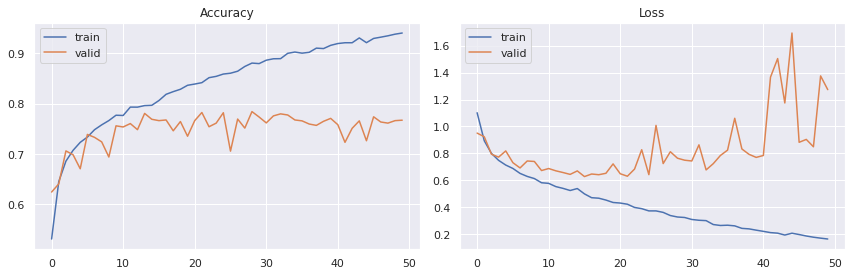

In [21]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [22]:
model.load_weights('/content/xception-29-0.78.hdf5')  

test accuracy: 78.5455 %


              precision    recall  f1-score   support

           0       0.81      0.54      0.65       283
           1       0.90      0.90      0.90       684
           2       0.65      0.88      0.75       430
           3       0.78      0.59      0.67       253

    accuracy                           0.79      1650
   macro avg       0.78      0.73      0.74      1650
weighted avg       0.80      0.79      0.78      1650



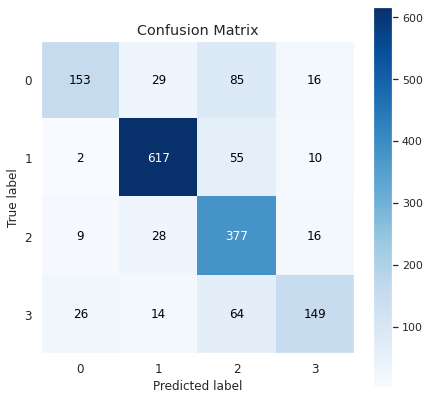

In [23]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))
